### Matching

In [1]:
import pandas as pd
import random

In [3]:
df = pd.read_csv('sample')
df

,smoker,treatment,dead
0,0,0,0
1,1,1,0
2,1,1,0
3,0,1,0
4,0,0,0
...,...,...,...
999995,0,0,0
999996,1,1,0
999997,0,0,0
999998,0,0,0


In [6]:
treated = df[df['treatment']==1]
untreated = df[df['treatment']==0]
# treated

In [7]:
dead_t = treated['dead'].mean()
dead_t

0.32080451312239394

In [8]:
dead_c = untreated['dead'].mean()
dead_c

0.23595664229896648

In [9]:
dead_t - dead_c

0.08484787082342746

### Method 1 (PS)

$$e(smoker) = p(treatment=1|smoker) $$

In [11]:
n_smokers = len(df[df['smoker']==1])
n_smokers_t = len(df[(df['smoker']==1)&(df['treatment']==1)])
e_smoker = n_smokers_t/n_smokers
e_smoker

0.551550247155304

In [12]:
n_nonsmokers = len(df[df['smoker']==0])
n_nonsmokers_t = len(df[(df['smoker']==0)&(df['treatment']==1)])
e_nonsmoker = n_nonsmokers_t/n_nonsmokers
e_nonsmoker

0.20002946321174753

In [13]:
df['propenstity'] = df['smoker']*e_smoker + (1- df['smoker'])*e_nonsmoker

In [17]:
treated = df[df['treatment']==1].sample(1000).reset_index(drop=True)
treated

,smoker,treatment,dead,propenstity
0,1,1,0,0.551550
1,0,1,0,0.200029
2,1,1,0,0.551550
3,1,1,1,0.551550
4,0,1,0,0.200029
...,...,...,...,...
995,1,1,0,0.551550
996,1,1,1,0.551550
997,1,1,1,0.551550
998,1,1,1,0.551550


In [21]:
untreated = df[df['treatment']==0]
matched = []
def add_matched(patient):
    control_patient = untreated[untreated['propenstity']==patient['propenstity']].sample().iloc[0]
    matched.append(control_patient)

In [22]:
treated.apply(add_matched, axis=1)

0      None
1      None
2      None
3      None
4      None
       ... 
995    None
996    None
997    None
998    None
999    None
Length: 1000, dtype: object

In [24]:
# matched

In [25]:
matched_df  = pd.DataFrame(matched).reset_index(drop=True)

In [27]:
paired_df = treated.join(matched_df, rsuffix='_control')
paired_df

,smoker,treatment,dead,propenstity,smoker_control,treatment_control,dead_control,propenstity_control
0,1,1,0,0.551550,1.0,0.0,1.0,0.551550
1,0,1,0,0.200029,0.0,0.0,0.0,0.200029
2,1,1,0,0.551550,1.0,0.0,1.0,0.551550
3,1,1,1,0.551550,1.0,0.0,1.0,0.551550
4,0,1,0,0.200029,0.0,0.0,0.0,0.200029
...,...,...,...,...,...,...,...,...
995,1,1,0,0.551550,1.0,0.0,1.0,0.551550
996,1,1,1,0.551550,1.0,0.0,1.0,0.551550
997,1,1,1,0.551550,1.0,0.0,1.0,0.551550
998,1,1,1,0.551550,1.0,0.0,1.0,0.551550


In [28]:
ATE = (paired_df['dead'] - paired_df['dead_control']).mean()
ATE

-0.161

$$ATE = -0.083$$

### Method 2

array([[<AxesSubplot:title={'center':'propenstity'}>]], dtype=object)

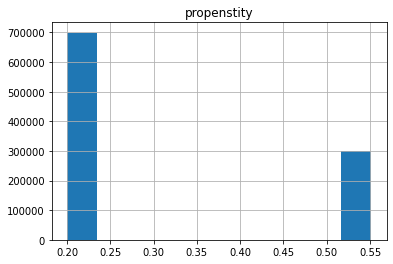

In [29]:
df.hist('propenstity')

In [38]:
high_ps = df[df['propenstity']>0.5]
low_ps = df[df['propenstity']<=0.5]

In [32]:
percentages = np.array([len(low_ps),len(high_ps)])/len(df)
percentages

array([0.699177, 0.300823])

In [39]:
n = 1000 
samples = []
for i in range(n):
    is_high = random.random()>percentages[0]
    if is_high:
        treated_p =  high_ps[high_ps['treatment']==1].sample().iloc[0]
        untreated_p =  high_ps[high_ps['treatment']==0].sample().iloc[0]
    else: 
        treated_p =  low_ps[low_ps['treatment']==1].sample().iloc[0]
        untreated_p =  low_ps[low_ps['treatment']==0].sample().iloc[0]
    samples.append((treated_p, untreated_p))

In [42]:
inv_te = np.zeros(n)
i = 0
for t,c in samples:
    inv_te[i] = t['dead'] - c['dead']
    i += 1


In [43]:
ATE = inv_te.mean()
ATE

-0.097

### Method 3 (Subclassification on PS)

$$ATE = P_1 * ATE_1 + \dots +  P_k * ATE_k $$

In [44]:
high_ps = df[df['propenstity']>0.5]
low_ps = df[df['propenstity']<=0.5]

percentages = np.array([len(low_ps),len(high_ps)])/len(df)
percentages

array([0.699177, 0.300823])

In [52]:
high_t = high_ps[high_ps['treatment']==1]
high_c = high_ps[high_ps['treatment']==0]
ATE_high = high_t['dead'].mean() -  high_c['dead'].mean() 
ATE_high

-0.30154970389303043

In [53]:
low_t = low_ps[low_ps['treatment']==1]
low_c = low_ps[low_ps['treatment']==0]
ATE_low = low_t['dead'].mean() -  low_c['dead'].mean() 
ATE_low

0.010967865389731754

In [55]:
ATE = percentages[0]*ATE_low+ percentages[1]*ATE_high
ATE

-0.0830446073546166